In [39]:
import torch
from torch import nn
from torch.utils.data import dataset, DataLoader, Dataset

import unicodedata
import string
import glob
import os

In [40]:
ALL_CHARS = string.ascii_letters + " .,;'" + "_"
N_CHARS = len(ALL_CHARS)

def unicodeToAscii(s: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_CHARS
    )

In [41]:
def letterToIndex(letter: str) -> str:
    idx = ALL_CHARS.find(letter)
    if idx == -1:
        idx = ALL_CHARS.find("_")
    
    return idx

In [42]:
def lineToTensor(line: str) -> str:
    line = unicodeToAscii(line)
    tensor = torch.zeros(len(line), 1, N_CHARS)

    for i, char in enumerate(line):
        tensor[i, 0, letterToIndex(char)] = 1.0
    
    return tensor

In [43]:
data_dir = "data/names"
data_dir

'data/names'

In [44]:
all_files = glob.glob(os.path.join(data_dir, "*.txt"))
os.path.basename(all_files[0])

'Arabic.txt'

In [45]:
os.path.splitext(os.path.basename(all_files[0]))

('Arabic', '.txt')

In [58]:
class NameDataset(Dataset):
    def __init__(self, data_dir="data/names"):
        super().__init__()
        self.data_dir = data_dir
        self.samples = []
        self.all_labels = set()

        for files in glob.glob(os.path.join(data_dir, "*.txt")):
            language_label = os.path.splitext(os.path.basename(files))[0]
            self.all_labels.add(language_label)
        
        self.all_labels = sorted(list(self.all_labels))
        self.label_to_index = {label: i for i, label in enumerate(self.all_labels)}

        for files in glob.glob(os.path.join(data_dir, "*.txt")):
            language_label = os.path.splitext(os.path.basename(files))[0]
            label_index = self.label_to_index[language_label]

            with open(files, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if line == "":
                        continue
                    name_tensor = lineToTensor(line)
                    self.samples.append((name_tensor, label_index))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        name_tensor, label_index = self.samples[index]
        return name_tensor, label_index
    
    def num_categories(self):
        return len(self.all_labels)
    
    def labels(self):
        return self.all_labels

In [59]:
# Create the dataset
dataset = NameDataset("data/names")
print(f"Total samples = {len(dataset)}")
print(f"Unique languages = {dataset.all_labels}")


Total samples = 20074
Unique languages = ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [60]:
class SimpleRNN(nn.Module):
    def __init__(self, 
                 input_size:int,
                 hidden_units: int,
                 output_size: int):
        
        super().__init__()
        
        self.input_size = input_size
        self.hidden_units = hidden_units
        self.output_size = output_size

        self.i2h = nn.Linear(input_size, hidden_units)
        self.h2h = nn.Linear(hidden_units, hidden_units)
        self.h2o = nn.Linear(hidden_units, output_size)
    
    def forward(self,
                x: torch.Tensor,
                hidden_state: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        
        x = self.i2h(x)
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        return self.h2o(hidden_state), hidden_state
    
    def init_zero_hidden(self,
                         batch_size = 1) -> torch.Tensor:
        
        return torch.zeros(batch_size, self.hidden_units, requires_grad=False)

In [79]:
def name_collate_fn(batch):

    max_length = max(x[0].size(0) for x in batch)

    batch_size = len(batch)
    padded_input = torch.zeros(batch_size, max_length, N_CHARS)
    labels = torch.zeros(batch_size, dtype=torch.long)

    for i, (name_tensor, label_idx) in enumerate(batch):
        seq_len = name_tensor.size(0)

        name_tensor_squeezed = name_tensor.squeeze(1)
        padded_input[i, :seq_len, :] = name_tensor_squeezed
        labels[i] = label_idx
    
    return padded_input, labels

In [80]:
train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=name_collate_fn)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=name_collate_fn
)

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [101]:
model = SimpleRNN(input_size=N_CHARS,
                  hidden_units=256,
                  output_size=dataset.num_categories()).to(device)
model

SimpleRNN(
  (i2h): Linear(in_features=58, out_features=256, bias=True)
  (h2h): Linear(in_features=256, out_features=256, bias=True)
  (h2o): Linear(in_features=256, out_features=18, bias=True)
)

In [102]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [103]:
def train(model,
          dataloader,
          optimizer,
          loss_fn,
          device):
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        batch_size, seq_length, _ = X.size()
        hidden_state = model.init_zero_hidden(batch_size).to(device)

        out = None

        for j in range(seq_length):
            x = X[:,j,:]
            out, hidden_state = model(x, hidden_state)
        
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = out.max(1)
        train_acc += (predicted == y).sum().item() / len(predicted)
    
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [104]:
def test(model,
         dataloader,
         loss_fn,
         device):
    
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            batch_size, seq_length, _ = X.size()
            hidden_state = model.init_zero_hidden(batch_size).to(device)

            out = None

            for j in range(seq_length):
                x = X[:, j, :]
                out, hidden_state = model(x, hidden_state)
            
            loss = loss_fn(out, y)

            test_loss += loss.item()
            _, predicted = out.max(1)
            test_acc += (predicted == y).sum().item() / len(predicted)
    
    epoch_loss = test_loss / len(dataloader)
    epoch_acc = test_acc / len(dataloader)
    print(f"Test Loss {epoch_loss} Accuracy {epoch_acc}")
    
    return epoch_loss, epoch_acc

In [105]:
def train_and_test(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    import matplotlib.pyplot as plt

    overall_train_losses = []
    overall_train_accuracies = []
    overall_test_losses = []
    overall_test_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        # Train for one epoch (the train() function returns lists; we take the last value)
        train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn, device)
        epoch_train_loss = train_loss
        epoch_train_acc = train_acc
        overall_train_losses.append(epoch_train_loss)
        overall_train_accuracies.append(epoch_train_acc)

        # Test on the test set
        epoch_test_loss, epoch_test_acc = test(model, test_dataloader, loss_fn, device)
        overall_test_losses.append(epoch_test_loss)
        overall_test_accuracies.append(epoch_test_acc)
        print(f"Epoch {epoch+1}: Train Loss {epoch_train_loss:.4f} Acc {epoch_train_acc:.4f} | Test Loss {epoch_test_loss:.4f} Acc {epoch_test_acc:.4f}")

    # Plotting the graphs
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, overall_train_losses, label="Train Loss")
    plt.plot(epochs_range, overall_test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, overall_train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, overall_test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return overall_train_losses, overall_train_accuracies, overall_test_losses, overall_test_accuracies

Epoch 1/50
Test Loss 1.8609003112429665 Accuracy 0.4101828231292517
Epoch 1: Train Loss 1.8369 Acc 0.4671 | Test Loss 1.8609 Acc 0.4102
Epoch 2/50
Test Loss 1.500804581339397 Accuracy 0.5498511904761905
Epoch 2: Train Loss 1.5782 Acc 0.5313 | Test Loss 1.5008 Acc 0.5499
Epoch 3/50
Test Loss 1.301123882569964 Accuracy 0.6369756235827664
Epoch 3: Train Loss 1.4567 Acc 0.5776 | Test Loss 1.3011 Acc 0.6370
Epoch 4/50
Test Loss 1.1914883478293343 Accuracy 0.6672335600907029
Epoch 4: Train Loss 1.3228 Acc 0.6272 | Test Loss 1.1915 Acc 0.6672
Epoch 5/50
Test Loss 1.1251224232098413 Accuracy 0.6893778344671202
Epoch 5: Train Loss 1.2337 Acc 0.6518 | Test Loss 1.1251 Acc 0.6894
Epoch 6/50
Test Loss 1.1346693928279574 Accuracy 0.6787840136054422
Epoch 6: Train Loss 1.1499 Acc 0.6769 | Test Loss 1.1347 Acc 0.6788
Epoch 7/50
Test Loss 1.1067299828642891 Accuracy 0.6834963151927437
Epoch 7: Train Loss 1.0780 Acc 0.6984 | Test Loss 1.1067 Acc 0.6835
Epoch 8/50
Test Loss 0.9489506277300063 Accuracy 0

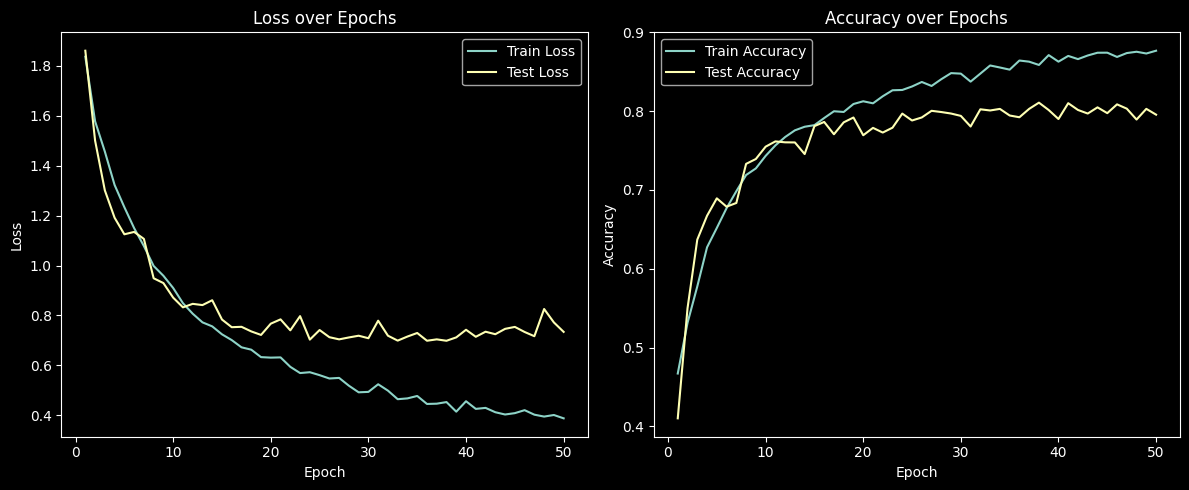

([1.8368767901245817,
  1.5781696866233035,
  1.4567119048173685,
  1.3228168456677896,
  1.2337365270373355,
  1.1498898007124068,
  1.0780029240476183,
  0.9982277125832569,
  0.9588316474184096,
  0.9098994769304397,
  0.8490848173183274,
  0.806971390022937,
  0.7722598757164412,
  0.756160421883205,
  0.7242209860290664,
  0.7011498373699379,
  0.6722020567413345,
  0.662712988892637,
  0.6328824876521926,
  0.630861832608146,
  0.6318208007698515,
  0.5939481455788195,
  0.5690605324578,
  0.5724093963900411,
  0.5606383499040072,
  0.5472502461467607,
  0.5495882943064806,
  0.5183482470354474,
  0.4918959157103561,
  0.4935851073360063,
  0.5240726990410056,
  0.49864310021716285,
  0.4642868644420607,
  0.46751289421403075,
  0.477245537452845,
  0.4452047499928223,
  0.4462919654881218,
  0.4527487584289564,
  0.4143178979921863,
  0.4561106707915604,
  0.4254380613862281,
  0.42946792800587963,
  0.4120416886421789,
  0.4029442929121039,
  0.40838901147958767,
  0.4203241051

In [106]:
train_and_test(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=50, device=device)